# Convolutional Layer
합성곱 층은 이미지나 시계열 같은 고차원 입력 데이터에서 국소적인 특징(local features) 을 추출하는 데 매우 효과적인 신경망 구조입니다. 

## Mathematical formulation
입력 이미지는 3차원 텐서로 표현됩니다:
$$
\mathbf{x} \in \mathbb{R}^{C \times H \times W}
$$
- $C$: 입력 채널 수 (예: RGB 이미지의 경우 $C = 3$)
- $H, W$: 입력 이미지의 높이(height)와 너비(width)

하나의 필터(커널)는 다음과 같은 텐서로 주어집니다:
$$
\mathbf{w} \in \mathbb{R}^{C \times K \times K}
$$
- $K$: 필터의 크기 (예: $K=3$이면 $3 \times 3$ 필터)

Stride = 1, Padding = 0일 때, Convolution 연산의 출력 텐서 $\mathbf{y}$는 다음과 같이 주어집니다:

$$
\mathbf{y}[h, w] = \sum_{c=0}^{C-1} \sum_{i=0}^{K-1} \sum_{j=0}^{K-1} \mathbf{x}[c, h + i, w + j] \cdot \mathbf{w}[c, i, j] + b
$$

- $\mathbf{y} \in \mathbb{R}^{(H - K + 1) \times (W - K + 1)}$ 
- $b \in \mathbb{R}$: bias 
- 텐서에서 대괄호 $[\;]$는 특정 위치의 값을 인덱싱하는 것을 의미합니다.


<mark>실습</mark> `custom_conv2d`함수를 완성하세요
- `for` loop는 <u>최대 2개까지만</u> 사용할 수 있습니다.
- [`torch.zeros`](https://pytorch.org/docs/stable/generated/torch.zeros.html)를 이용하여 출력 텐서 `output`을 초기화 하세요

In [7]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def custom_conv2d(input_tensor, filter_weights, filter_bias):
    """
    Performs a 2D convolution (stride=1, padding=0) on a multi-channel input tensor.
     
    Args:
        input_tensor (torch.Tensor): Input image tensor with shape (C, H, W)
        filter_weights (torch.Tensor): Convolution filter weights with shape (C, k, k)
        filter_bias (torch.Tensor): A scalar bias added after covolution
        
    Returns:
        output (torch.Tensor): Output tensor (feature map)
    """
    
    C, H, W = input_tensor.shape
    _, k, _ = filter_weights.shape
    
    ##### YOUR CODE START #####  
    stride = 1
    
    k = filter_weights.shape[2]
    out_H = (H - k) // stride + 1
    out_W = (W - k) // stride + 1

    output = torch.zeros((out_H, out_W))

    for i in range(out_H):
        for j in range(out_W):
            region = input_tensor[:, i*stride:i*stride+k, j*stride:j*stride+k]
            output[i, j] = torch.sum(region * filter_weights) + filter_bias
    ##### YOUR CODE END #####

    return output

In [8]:
img = Image.open("resources/sudoku.jpg").convert("RGB")
img_tensor = torch.from_numpy(np.array(img)).permute(2, 0, 1).float() / 255

filter_weights = torch.tensor([
    [[ -1.0,  0.0, 1.0],
     [ -1.0,  0.0, 1.0],
     [ -1.0,  0.0, 1.0]],
    
    [[ -1.0,  0.0, 1.0],
     [ -1.0,  0.0, 1.0],
     [ -1.0,  0.0, 1.0]],

    [[ -1.0,  0.0, 1.0],
     [ -1.0,  0.0, 1.0],
     [ -1.0,  0.0, 1.0]],
], dtype=torch.float)
filter_bias = 0

conv_output = custom_conv2d(img_tensor, filter_weights, filter_bias)
print("conv_output shape: ", conv_output.shape)

# Tests
assert type(conv_output) == torch.Tensor, "Output should be torch.Tensor"
assert conv_output.shape == torch.Size([421, 417]), "Output tensor shape incorrect"
assert torch.allclose(conv_output.sum(), torch.tensor(530022.0) / 255, rtol = 1e-2), "custom_conv2d output tensor value incorrect"
assert torch.allclose(conv_output.sum(axis = 0)[207:212], torch.tensor([-28707.0, -10893.0, 14067.0, 21816.0, 16683.0]) / 255, rtol = 1e-1), "custom_conv2d output tensor value incorrect"
print('\033[92mAll tests passed!')

conv_output shape:  torch.Size([421, 417])
All tests passed!


하나의 filter로 convlution연산을 수행했으므로 출력 텐서는 1개의 채널을 가집니다.

여기서 예시로 사용한 필터는  다음과 같이 수평 방향의 경계(edge)를 검출하는 역할을 합니다. 
$$
\begin{bmatrix}
-1 & 0 & 1 \\
-1 & 0 & 1 \\
-1 & 0 & 1 \\
\end{bmatrix}
$$

In [ ]:
original_img_np = img_tensor.permute(1, 2, 0).numpy()
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Display the original multi-channel image
axes[0].imshow(original_img_np)
axes[0].set_title('Original Image')

# Display the convolution output (grayscale)
convolved_abs = torch.abs(conv_output)
convolved_norm = (convolved_abs - convolved_abs.min()) / (convolved_abs.max() - convolved_abs.min() + 1e-8)
im = axes[1].imshow(convolved_norm.numpy(), cmap='gray')
axes[1].set_title('Convolved Image')
fig.colorbar(im, ax=axes[1])

plt.tight_layout()
plt.show()

# Training a Convolutional Neural Network

Convolutional Neural Network(CNN)은 일반적으로 다음과 같은 4가지 주요 레이어로 구성됩니다:

- Convolutional layer: 필터를 통해 지역적인 특징(feature)을 추출합니다
- Activation: 비선형성을 도입합니다 (예: ReLU).
- Pooling layer: 공간 크기를 줄이며 중요한 정보만 추출합니다.
- Fully-connected layer: 최종 예측을 위한 분류기 역할을 합니다.

### `nn.Conv2d`
`nn.Conv2d` ([docs](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html))는 4차원 입력 텐서 (batch, channel, height, width)에 대해 합성곱을 수행합니다.

- `in_channels` (int) : 입력 채널 수
- `out_channels` (int) : 출력 채널 수 = 사용하는 필터 개수
- `kernel_size` (int or tuple) : 필터 크기  (예: 3이면 3x3 필터).
- `stride` (int or tuple) : Stride (Default = 1)
- `padding` (int or tuple) : zero padding (Default = 0)

In [ ]:
import torch
from torch import nn

In [ ]:
input_image = torch.rand(16, 1, 28, 28) # dummy data with batch_size 16
conv_layer1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 5)
conv_output = conv_layer1(input_image)
print("conv layer output.shape: ", conv_output.shape)

필터 수가 8개이므로, 출력 텐서는 (8, 24, 24)의 shape을 가집니다

### `nn.MaxPool2d`
풀링은 특징 맵의 크기를 줄여 계산량을 줄이고, 위치 변화에 대한 강인함을 향상시킵니다 ([docs](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)).
- `kernel_size` (int or tuple)
- `stride` (int or tuple): Default = `kernel_size`
- `padding` (int or tuple): Default = 0

In [ ]:
pool_layer = nn.MaxPool2d(kernel_size = 2, stride = 2)
pool_output = pool_layer(conv_output)
print("pooling layer output shape: ", pool_output.shape)

## CIFAR-10 dataset
이번 시간에는 CIFAR-10 dataset을 이용하여 이미지 분류 모델을 학습해보겠습니다.

CIFAR-10은 컴퓨터 비전 분야에서 널리 사용되는 벤치마크 이미지 데이터셋으로,
- 각 이미지는 32×32 해상도의 3채널(RGB) 컬러 이미지입니다.
- 비행기(airplane), 자동차(automobile), 새(bird), 고양이(cat) 등 총 10개의 클래스로 구성되어 있습니다.
- 학습 데이터는 50,000개, 테스트 데이터는 10,000개로 구성되어 있습니다.

In [10]:
import torch
from torch import nn
from torchvision import datasets, transforms
import torch.nn.functional as F

from train_utils import train_model, load_and_evaluate_model

In [11]:
def load_cifar10_datasets(data_root_dir):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5)) 
    ])
    
    train_dataset = datasets.CIFAR10(root=data_root_dir, train=True, download=False, transform=transform)
    test_dataset = datasets.CIFAR10(root=data_root_dir, train=False, download=False, transform=transform)

    return train_dataset, test_dataset

In [12]:
train_dataset, test_dataset = load_cifar10_datasets("/datasets")
print("train_dataset size: ", len(train_dataset))
print("test_dataset size: ", len(test_dataset))
print("train_dataset[0] image shape: ", train_dataset[0][0].shape)
print("train_dataset[0] label: ", train_dataset[0][1])

train_dataset size:  50000
test_dataset size:  10000
train_dataset[0] image shape:  torch.Size([3, 32, 32])
train_dataset[0] label:  6


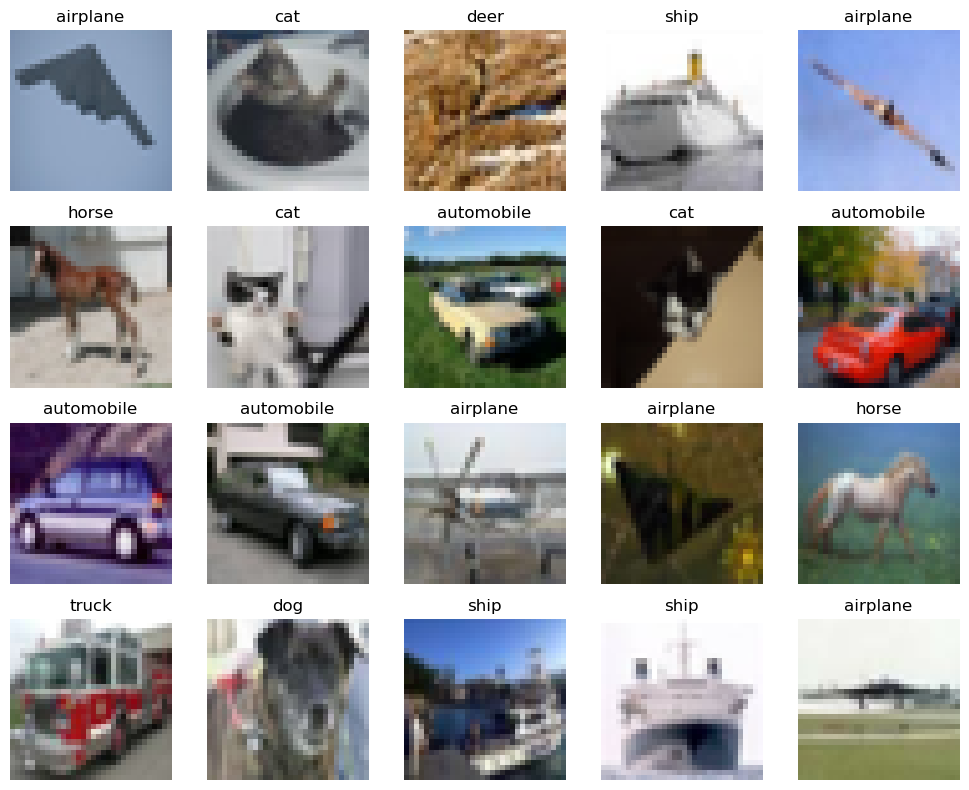

In [13]:
import matplotlib.pyplot as plt

def visualize_few_samples(dataset, cols=8, rows=5):
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']  # CIFAR10 class names

    figure, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2)) 
    axes = axes.flatten()

    for i in range(cols * rows):
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        img, label = dataset[sample_idx]
        img = img.permute(1, 2, 0)  # CHW to HWC
        img = img.numpy()  # Convert to numpy array
        img = (img * 0.5 + 0.5)  # Unnormalize to [0,1] for display
        axes[i].imshow(img)
        axes[i].set_title(class_names[label])
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
visualize_few_samples(train_dataset, cols = 5, rows = 4)

## Training a small CNN model

<mark>실습</mark> 아래 구조를 가지는 `SimpleCNN`을 완성하세요
1. **Conv1**: 7x7 Convolutional layer
   - 8 filters, strides of 1, no zero padding, and ReLU activation
2. **Pool1**: 2x2 Max pooling layer
   - stride of 2
3. **Conv2**: 4x4 Convolutional layer
   - 16 filters, strides of 1, no zero padding, and ReLU activation
4. **Pool2**: 2x2 Max pooling layer
   - stride of 2
5. **FC1**: Fully connected layer
   - 128 output units, ReLU activation
6. **FC2**: Fully connected layer
   - 64 output units, ReLU activation
7. **FC3**: Fully connected layer
   - 10 output units (CIFAR-10 클래스 수)

힌트
- CIFAR-10 데이터셋 입력 이미지 크기는 `(3, 32, 32)` 입니다
- [`nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
- [`nn.MaxPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)
- [`nn.Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) 혹은 [`torch.tensor.view`](https://pytorch.org/docs/stable/generated/torch.Tensor.view.html)를 활용하세요



In [49]:
class SimpleCNN(nn.Module):
    def __init__(self, out_dim):
        super().__init__()
        ##### YOUR CODE START #####
        self.conv1 = nn.Conv2d(3, 8, kernel_size=7, stride=1, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=4, stride=1, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, out_dim)
        ##### YOUR CODE END #####

    def forward(self, x):
        ##### YOUR CODE START #####
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = self.fc3(x)
        ##### YOUR CODE END #####
        return logits

In [50]:
# Test forward pass
model = SimpleCNN(out_dim = 10)
print(model)

X = torch.rand(16, 3, 32, 32) # dummy data for testing with batch_size 16
logits = model(X) 

print("\nlogits.shape: ", logits.shape)

SimpleCNN(
  (conv1): Conv2d(3, 8, kernel_size=(7, 7), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(4, 4), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

logits.shape:  torch.Size([16, 10])


<mark>실습</mark> 앞서 정의한 `model = SimpleCNN(out_dim = 10)`의 파라미터 수를 직접 손으로 계산하여 숫자로 기입해보세요 (숫자 계산식으로 입력해도 괜찮으나 파이썬 변수를 사용하지 마세요)
 - bias를 포함하는것을 잊지 마세요


In [51]:
num_params_conv1 = 1184  # TODO: number of parameters in Conv1 layer
num_params_pool1 = 0 # TODO: number of parameters in Pool1 layer
num_params_conv2 = 2064  # TODO: number of parameters in Conv2 layer
num_params_pool2 = 0 # TODO: number of parameters in Pool2 layer
num_params_fc1 = 51328  # TODO: number of parameters in FC1 layer
num_params_fc2 = 8256# TODO: number of parameters in FC2 layer
num_params_fc3 = 650 # TODO: number of parameters in FC3 layer

In [52]:
total_params = (num_params_conv1  + num_params_pool1 + num_params_conv2 + num_params_pool2 + num_params_fc1 + num_params_fc2 + num_params_fc3)

print(f"Total number of params : {total_params}")

assert sum(p.numel() for p in model.parameters() if p.requires_grad) == total_params, "❌ 계산한 파라미터 수가 실제 모델과 일치하지 않습니다."
print('\033[92mAll tests passed!')

Total number of params : 63482
All tests passed!


<mark>실습</mark> 아래 코드를 이용하여 `SimpleCNN`모델을 학습해보고 WandB에서 결과를 살펴보세요

In [53]:
def main_SimpleCNN(config):
    train_dataset, test_dataset = load_cifar10_datasets(config["data_root_dir"])
    num_classes = len(train_dataset.classes)

    model = SimpleCNN(out_dim=num_classes)

    print(f"Using {config['device']} device")
    print("Number of trainable model parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

    if config["mode"] == "train":
        test_accuracy = train_model(model, train_dataset, test_dataset, config)
    elif config["mode"] == "eval":
        test_accuracy = load_and_evaluate_model(model, test_dataset, config)
    else:
        raise ValueError(f"Unknown mode: {config['mode']}")
    
    return test_accuracy

In [55]:
config = {
    "mode": "train",  # Options: "train", "eval"
    "device": "cuda" if torch.cuda.is_available() else "cpu",

    ## data and preprocessing settings
    "data_root_dir": '/datasets',
    "num_workers": 4,

    ## Training Hyperparams
    "batch_size": 128,
    "learning_rate": 1e-2,
    "num_epochs": 50,

    ## checkpoints
    "checkpoint_path": "checkpoints/checkpoint.pth",    # Path to save the most recent checkpoint
    "best_model_path": "checkpoints/best_model.pth",    # Path to save the best model checkpoint
    "checkpoint_save_interval": 1,                     # Save a checkpoint every N epochs
    "resume_training": None,    # Options: "latest", "best", or None

    ## WandB logging
    "wandb_project_name": "CIFAR10-experiments",
    "wandb_experiment_name" : "SimpleCNN",
    "model_architecture": "CNN",
    "dataset_name": "CIFAR10"
}

main_SimpleCNN(config)

Using cuda device
Number of trainable model parameters:  63482


Validation/Test: 100%|██████████| 79/79 [00:00<00:00, 360.16it/s, avg_metrics=Loss: 1.0715e+00 (n=10000), Accuracy:  62.67 (n=10000)]


Test Accuracy,▁▁▂▃▄▄▅▅▆▅▆▆▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇█████████████
Test Loss,████▆▅▅▄▄▄▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▁▁▂▃▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████
Train Loss,████▆▆▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Test Accuracy,62.67
Test Loss,1.0715
Train Accuracy,67.12
Train Loss,0.94313
epoch,49


62.75

## BetterCNN Architecture Search
<mark>실습</mark> 더 높은 이미지 분류 정확도를 달성하기 위해, 더 나은 CNN모델 `BetterCNN`를 직접 설계해보세요. 

 - 주어진 `BetterCNN` 클래스 안의 모델 구조를 자유롭게 설계하여 `test set accuracy > 68.0%`를 달성하세요
 - `BetterCNN`의 모델 구조와 `learning_rate`, `num_epochs`는 자유롭게 변경할 수 있습니다. 단, 그 외에 <u>다른 것은 변경할 수 없습니다</u>.
   - 예를들어 optimizer, learning rate scheduler 등과 같은 다른 하이퍼파라미터는 모두 고정이며, 모델 구조(`BetterCNN`) 개선을 통해 최고의 성능을 달성해보세요.
   - 사용할 수 있는 PyTorch 레이어는 다음으로 제한됩니다: `nn.Sequential`, `nn.Conv2d`, `nn.MaxPool2d`, `nn.ReLU()`, `nn.Linear`, `nn.Flatten()`
     - 그 외의 다른 `nn` 모듈이나 `torchvision.models`는 <u>사용 불가</u>합니다.
 - <mark>주의</mark> 해당 정확도를 달성한 모델의 checkpoint 파일(`submitted_checkpoints/best_model.pth`)을 github에 함께 push하세요.

You may experiment with various:
- Filter size
- Number of filters
- Stride
- zero padding size
- Pooling layer 
- number of layers
- ...

힌트
- 3개의 Conv layer와 2개의 FC layer만으로도 목표하는 성능에 도달할 수 있습니다.
- `Conv2d`연산과 `MaxPool2d` 연산을 거차면 이미지의 공간 크기(Height, Width)는 점점 줄어듭니다. 따라서 Conv layer가 깊어질수록 채널 수(필터 수)를 늘어주어, 줄어든 공간 정보만큼 더 풍부한 특징(feature)을 추출할 수 있도록 합니다.
- `Linear` layer는 합성곱(conv) 계층에서 추출한 특징(feature) 중에서 최종 예측(분류)에 중요한 정보들을 선별하고 통합하는 역할을 합니다. 따라서 layer가 깊어질수록 출력 차원을 점차 줄여가며, 점점 더 핵심적인 특징을 추출하도록 만드는 것이 일반적입니다.

In [44]:
class BetterCNN(nn.Module):
    def __init__(self, out_dim):
        super().__init__()

        ##### YOUR CODE START #####
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, out_dim)


        ##### YOUR CODE END #####

    def forward(self, x):
        ##### YOUR CODE START #####  
        x = self.conv(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)


        ##### YOUR CODE END #####
        return logits

In [45]:
# Test forward pass
model = BetterCNN(out_dim = 10)
print(model)

X = torch.rand(16, 3, 32, 32) # dummy data for testing with batch_size 16
logits = model(X) 

print("\nlogits.shape: ", logits.shape)

BetterCNN(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

logits.shape:  torch.Size([16, 10])


<mark>주의</mark> 아래 `main_BetterMLP()`함수와 `config` 값을 수정하는것은 <u>허용되지 않습니다</u>
- `learning_rate`와 `num_epochs` 값을 변경해보는 것은 가능하나, `BetterCNN` 모델 구조를 개선하는 것이 성능 향상에 더 큰 도움이 됩니다.

In [46]:
def main_BetterCNN(config):
    train_dataset, test_dataset = load_cifar10_datasets(config["data_root_dir"])
    num_classes = len(train_dataset.classes)

    model = BetterCNN(out_dim=num_classes)

    print(f"Using {config['device']} device")
    print("Number of trainable model parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

    if config["mode"] == "train":
        test_accuracy = train_model(model, train_dataset, test_dataset, config)
    elif config["mode"] == "eval":
        test_accuracy = load_and_evaluate_model(model, test_dataset, config)
    else:
        raise ValueError(f"Unknown mode: {config['mode']}")
    
    return test_accuracy

config = {
    "mode": "train",  # Options: "train", "eval"
    "device": "cuda" if torch.cuda.is_available() else "cpu",

    ## data and preprocessing settings
    "data_root_dir": '/datasets',
    "num_workers": 4,

    ## Training Hyperparams
    "batch_size": 128,
    "learning_rate": 1e-2,
    "num_epochs": 50,

    ## checkpoints
    "checkpoint_path": "submitted_checkpoints/checkpoint.pth",    # Path to save the most recent checkpoint
    "best_model_path": "submitted_checkpoints/best_model.pth",    # Path to save the best model checkpoint
    "checkpoint_save_interval": 1,                     # Save a checkpoint every N epochs
    "resume_training": None,    # Options: "latest", "best", or None

    ## WandB logging
    "wandb_project_name": "CIFAR10-experiments",
    "wandb_experiment_name" : "BetterCNN",
    "model_architecture": "CNN",
    "dataset_name": "CIFAR10"
}

In [47]:
main_BetterCNN(config)

Using cuda device
Number of trainable model parameters:  356810


Validation/Test: 100%|██████████| 79/79 [00:00<00:00, 366.31it/s, avg_metrics=Loss: 8.5685e-01 (n=10000), Accuracy:  71.25 (n=10000)]


Test Accuracy,▁▂▃▃▄▅▅▅▅▆▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇▇██████
Test Loss,█▇▆▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▂▂▂▁▁▁▁▁▁
Train Accuracy,▁▂▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████
Train Loss,█▇▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Test Accuracy,71.25
Test Loss,0.85685
Train Accuracy,82.072
Train Loss,0.52146
epoch,49


73.04

<mark>주의</mark> 실습 과제를 제출하기 전 아래 코드를 통해 저장된 checkpoint가 `test set accuracy > 68.0%`의 성능을 달성했는지 다시 한번 확인해보세요.

In [48]:
config["mode"] = "eval"
main_BetterCNN(config)

Using cuda device
Number of trainable model parameters:  356810
=> loaded checkpoint 'submitted_checkpoints/best_model.pth' (epoch 49)


Validation/Test: 100%|██████████| 79/79 [00:00<00:00, 354.98it/s, avg_metrics=Loss: 7.9949e-01 (n=10000), Accuracy:  73.04 (n=10000)]

Test-set Accuracy: 73.04%


73.04